# Optimization Method: FOPDT to Data<div id='wikitext'>
<p class='vspace'>A first-order linear system with time delay is a common empirical description of many stable dynamic processes. The equation
</p>
<p class='vspace'>$$\tau_p \frac{dy(t)}{dt} = -y(t) + K_p u\left(t-\theta_p\right)$$
</p>
<p class='vspace'>has variables <em>y(t)</em> and <em>u(t)</em> and three unknown parameters.
</p>
<p class='vspace'>$$K_p \quad \mathrm{= Process \; gain}$$
</p>
<p class='vspace'>$$\tau_p \quad \mathrm{= Process \; time \; constant}$$
</p>
<p class='vspace'>$$\theta_p \quad \mathrm{= Process \; dead \; time}$$
</p>
<p class='vspace'>These variables may be adjusted to match data. An explicit solution to the above equation for each time step <em>j</em> is:
</p>
<p class='vspace'>$$y_j = e^{\frac{-\Delta\,t}{\tau_p}} \left(y_{j-1}-y_0\right) + \left(1-e^{\frac{-\Delta\,t}{\tau_p}}\right) \, K_p \, \left(u_{j-\theta_p-1}-u_0\right) + y_0$$
</p>
<p class='vspace'>where `\Delta t` is the time step length, `y_0` is the initial output or steady state condition, `u_0` is the initial input or steady state condition, `y_{j-1}` and `u_{j-1}` are values from the prior step and `\theta_p` is the dead-time measured in number of time steps. When the matching process employs optimization, a model prediction is aligned with the measured values with the use of a solver. The solver often minimizes a measure of the alignment such as a sum of squared errors or sum of absolute errors. An optimization solver for Python is the SciPy.Optimize.Minimize function. Below is a tutorial on solving nonlinear optimization problems in Python.
</p>
<div class='vspace'></div>
<iframe width="560" height="315" src="https://www.youtube.com/embed/cXHvC_FGx24" frameborder="0" allowfullscreen></iframe>

<p class='vspace'>The optimization can be applied to dynamic models as well. Below are tutorial examples using Excel or Python to adjust the parameters to fit the model predictions to data. Unlike a <a class='wikilink' href='http://apmonitor.com/pdc/index.php/Main/FirstOrderGraphical'>graphical method to fit an FOPDT model</a>, optimization methods do not require a single step response but may include any sequence of input changes that produce a response in the output. 
</p>
<div class='vspace'></div><h4>Fit FOPDT to Data with Excel</h4>

<iframe width="560" height="315" src="https://www.youtube.com/embed/eXco8_3MmjI" frameborder="0" allowfullscreen></iframe>

<div class='vspace'></div><h4>Fit FOPDT to Data with Python</h4>

<iframe width="560" height="315" src="https://www.youtube.com/embed/RVnId1hU7qE" frameborder="0" allowfullscreen></iframe>

<p class='vspace'>An alternative to the graphical fitting approach is to use optimization to best match an FOPDT model to data or a more complex model. A common objective is to minimize a sum of squared error that penalizes deviation of the FOPDT model from the data. The optimization algorithm changes the parameters `K_p, \tau_p, \theta_p` to best match the data at specified time points.
</p>


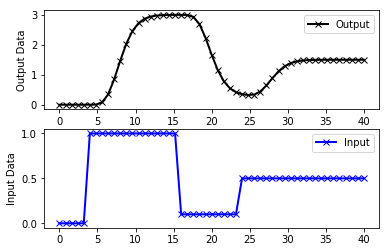

In [2]:
# Generate process data as data.txt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline
# define process model (to generate process data)
def process(y,t,n,u,Kp,taup):
    # arguments
    #  y[n] = outputs
    #  t    = time
    #  n    = order of the system   
    #  u    = input value
    #  Kp   = process gain
    #  taup = process time constant

    # equations for higher order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0] = (-y[0] + Kp * u)/(taup/n)
    for i in range(1,n):
       dydt[i] = (-y[i] + y[i-1])/(taup/n)
    return dydt

# specify number of steps
ns = 50
# define time points
t = np.linspace(0,40,ns+1)
delta_t = t[1]-t[0]
# define input vector
u = np.zeros(ns+1)
u[5:20] = 1.0
u[20:30] = 0.1
u[30:] = 0.5

# use this function or replace yp with real process data
def sim_process_data():
    # higher order process
    n=10       # order
    Kp=3.0    # gain
    taup=5.0   # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)  # process
    for i in range(1,ns+1):
        if i==1:
            yp0 = np.zeros(n)
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i] = y[1][n-1]
    return yp
yp = sim_process_data()

# Construct results and save data file
# Column 1 = time
# Column 2 = input
# Column 3 = output
data = np.vstack((t,u,yp)) # vertical stack
data = data.T              # transpose data
np.savetxt('data.txt',data,delimiter=',')

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Output')
plt.ylabel('Output Data')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.legend(['Input'],loc='best')
plt.ylabel('Input Data')
plt.show()

Initial SSE Objective: 29.039149620329916
Final SSE Objective: 0.2970438976511464
Kp: 3.0145469672463627
taup: 1.8585132714921553
thetap: 2.936871675754289


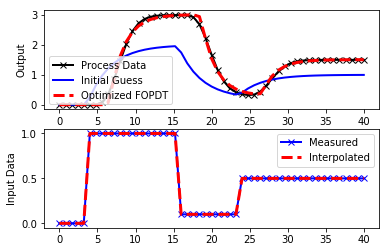

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',')
u0 = data[0,1]
yp0 = data[0,2]
t = data[:,0].T - data[0,0]
u = data[:,1].T
yp = data[:,2].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 2.0 # Km
x0[1] = 3.0 # taum
x0[2] = 0.0 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
#bnds = ((0.4, 0.6), (1.0, 10.0), (0.0, 30.0))
#solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()